In [301]:
### Package imports
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [300]:
### Constants
M_solar = 1.989e33 #g
R_solar = 6.96e10 #cm
L_solar = 3.847e33 #erg s-1
T_solar_eff = 6000 #K
G = 6.6726e-8 #g-1 cm3 s-2
N_A = 6.022e23 #mole-1
k = 1.381e-16 #cm2 g s-2 K-1
a = 7.5646e-15 #erg cm-3 K-4
c = 2.99e10 #cm s-2
m_H = 1.67e-24 #g
gamma = 5/3 #unitless
sigma = 5.67051e-5 #g s-3 K-4

### STRUCTURE PARAMETERS ###
M_tot = M_solar
X = .7
Y = .299
Z = 1-X-Y #.001
X_CNO = Z/2 #.0005

In [26]:
### STRUCTURE PARAMETERS ###
M_tot = M_solar
X = .7
Y = .299
Z = 1-X-Y #.001
X_CNO = Z/2 #.0005

In [327]:
### Opacity Table and Interpolation
opacity_table = np.loadtxt("Opacity Table.csv", skiprows=1, usecols= (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))


def get_opacity(T, R, opacity_table):
    logT = np.log10(T)
    logR = np.log10(R)
    
    if logT > 8.7:
        logT=8.7
    if logT < 3.75:
        logT=3.75
    if logR < -8:
        logR=-8
    if logR > 1:
        logR = 1
        
    logR_range = np.arange(-8.0, 1.1, .5)
    logT_range = np.concatenate((np.arange(3.75, 6, .05), np.arange(6, 8.1, .1), np.arange(8.1, 8.71, .2)))
    
    interpolated_opacity = sp.interpolate.interpn((logT_range, logR_range), opacity_table, (logT, logR))
    return np.exp(float(interpolated_opacity))


In [10]:
### Energy Generation Functions
def epsilon_pp(T, rho):
    phi = 1.2
    Z1 = 1
    Z2 = 1
    f11 = np.exp(5.92e-3 * Z1 * Z2 * (rho / (T/1e7)**3)**(1/2))
    g11 = 1 + 3.82*(T/1e9)**2 + 1.44*(T/1e9)**3 - 0.0114*(T/1e9)**4
    X1 = .7
    return 2.57e4 * phi * f11 * g11 * rho * X1**2 * (T/1e9)**(-2/3) * np.exp(-3.381/((T/1e9)**(1/3)))

def epsilon_CNO(T, rho):
    g14_1 = 1-2*(T/1e9) + 3.41*(T/1e9)**2 - 2.43*(T/1e9)**3
    XCNO = Z/2
    X1 = .7
    return 8.24e25 * g14_1 * XCNO * X1 * rho * (T/1e9)**(-2/3) * np.exp(-15.231*(T/1e9)**(-1/3)-((T/1e9)/.8)**2)



In [326]:
### Equation of State (both rho(r) and r(rho))
def P_of_rho(rho, T):
    mu = 4/(3+5*X)
    return (rho * N_A * k * T / mu) + a * T**4 / 3

def rho_of_P(P, T):
    mu = 4/(3+5*X)
    return (mu * (P-(a * T**4 / 3)) / (N_A * k * T))

In [325]:
### Interior & Exterior Parameter Inital Guesses (load1 & load2)
def interior_boundaries(P_var= 1, T_var= 1):
    mu = 4/(3+5*X)
    P_c = (3/(8*np.pi)) * G*M_solar**2/R_solar**4 * P_var
    L_0 = 0
    r_0 = 0
    T_c = (1/2) * G*M_solar/R_solar * mu/(N_A * k) * T_var
        
    return np.array([L_0, P_c, r_0, T_c])

def outer_boundaries():
    kappa = .34
    T_outer = T_solar_eff
    P_outer = (G * M_solar / R_solar**2) * (2/3) * (1/kappa)
    L_outer = L_solar
    r_outer = R_solar
    
    return np.array([L_outer, P_outer, r_outer, T_outer])

In [324]:
### differential equation functions, including small_m approximations
def nabla_ad():
    nabla = (gamma - 1) / gamma
    return nabla

def nabla_rad(m, l, P, T, kappa):
    return (3/(16*np.pi*a*c)) * (P * kappa / T**4) * (l / (G * m))

def dPdm(m, r, rho):
    return -G*m/(4*np.pi*r**4)
    
def dldm(epsilon):
    return epsilon

def drdm(r, rho):
    return 1/(4*np.pi*r**2*rho)

def dTdm(m, r, l, P, T, kappa):
    mu = 4/(3+5*X)
    rho = rho_of_P(P, T)
    if nabla_ad() > nabla_rad(m, l, P, T, kappa):
#         print("convective")
        return (-(3.0/(16.0*np.pi*a*c))*(kappa*rho/T**3)*(l/r**2))     
    else:
#         print("radidative")
        return (-1.0e0/((gamma - 1)/ gamma)*G*m/r**2*mu*m_H/k)
    
def small_m_r(m, rho_c):
    r = (3/(4*np.pi*rho_c))**(1/3) * m**(1/3)
    return r

def small_m_l(m, rho_c, T_c):
    epsilon = epsilon_pp(T_c, rho_c) + epsilon_CNO(T_c, rho_c)
    return m*epsilon

def small_m_P(m, rho_c, P_c):
    return P_c - 3*G/(8*np.pi)*(4*np.pi*rho_c/3)**(4/3)*m**(2/3)

def small_m_T(m, T_c, P_c, rho_c, kappa, epsilon):
    l = epsilon*m
    if nabla_ad() > nabla_rad(m, l, P_c, T_c, kappa):
#         print("convective")
        return np.exp( np.log(T_c) - (np.pi/6)**(1/3)*G*nabla_ad()*rho_c**(4/3)*m**(2/3)/ P_c )
    else:
#         print("radidative")
        return ( T_c**4 - (1/2*a*c) * (3/(4*np.pi))**(2/3) * kappa * epsilon * rho_c**(4/3) * m**(2/3) )**(1/4)

def get_small_m_points(m_final, P_var=1, T_var=1):
    m1=0
    m2=np.exp(np.log(m_final)/2)
    mf=m_final
    
    L_0, P_c, r_0, T_c = interior_boundaries(P_var, T_var)
    
    kappa_c = .2*(1+.34) 
    rho_c = rho_of_P(P_c, T_c)
    epsilon_c = epsilon_pp(T_c, rho_c) + epsilon_CNO(T_c, rho_c)
    
    pts1 = np.array([L_0, 
                     P_c, 
                     r_0, 
                     T_c])
    pts2 = np.array([small_m_l(m2, rho_c, T_c), 
                     small_m_P(m2, rho_c, P_c), 
                     small_m_r(m2, rho_c), 
                     small_m_T(m2, T_c, P_c, rho_c, kappa_c, epsilon_c)])
    pts3 = np.array([small_m_l(mf, rho_c, T_c), 
                     small_m_P(mf, rho_c, P_c), 
                     small_m_r(mf, rho_c), 
                     small_m_T(mf, T_c, P_c, rho_c, kappa_c, epsilon_c)])
    
    return np.array([pts1, pts2, pts3])
    
def outwardDerivs(V, m):
    
    l, P, r, T = V
    kappa = get_opacity(T, r/R_solar, opacity_table)
    rho = rho_of_P(P, T)
    epsilon = epsilon_pp(T, rho) + epsilon_CNO(T, rho)
    
    Dr = drdm(r, rho)
    Dl = dldm(epsilon)
    DP = dPdm(m, Dr, rho)
    DT = dTdm(m, Dr, l, P, T, kappa)
    return np.array([Dl, DP, Dr, DT])

def inwardDerivs(V, m):
        
    l, P, r, T = V
    kappa = get_opacity(T, r/R_solar, opacity_table)
    rho = rho_of_P(P, T)
    epsilon = epsilon_pp(T, rho) + epsilon_CNO(T, rho)
    
    Dr = -drdm(r, rho)
    Dl = -dldm(epsilon)
    DP = -dPdm(m, Dr, rho)
    DT = -dTdm(m, Dr, l, P, T, kappa)
    return np.array([Dl, DP, Dr, DT])

In [323]:
### ODE Solver (shootf)

m_step = M_solar/2000
L_0, P_c, r_0, T_c = interior_boundaries(P_var= 1, T_var= 1)
L_outer, P_outer, r_outer, T_outer = outer_boundaries()

m_f = 10*M_solar/2000 
m_int = M_solar/1.5

abserr = 1e-8
relerr = 1e-6
inwardpts = 10**np.linspace(np.log10(M_solar), np.log10(m_int), num=498)
outwardpts = 10**np.linspace(np.log10(m_int), np.log10(M_solar), num=498)

outward_dep_params = np.zeros((len(outwardpts), 4))
outward_dep_params[0] = np.array(get_small_m_points(m_f, P_var= 1, T_var= 1)[2])

inward_dep_params = np.zeros((len(inwardpts), 4))
inward_dep_params[0] = np.array([L_outer, P_outer, r_outer, T_outer])

for i in range(len(outwardpts)-1):
    derivs = outwardDerivs(outward_dep_params[i], outwardpts[i])
    next_mass_step_params = outward_dep_params[i] + np.array([derivs])
    outward_dep_params[i+1] = next_mass_step_params

for i in range(len(inwardpts)-1):
    derivs = inwardDerivs(inward_dep_params[i], inwardpts[i])
    next_mass_step_params = inward_dep_params[i] + np.array([derivs])
    inward_dep_params[i+1] = next_mass_step_params


In [329]:
### Repeated shootf calling until convergence (newt)
#initial guesses for boundary conditions:
L_0, P_c, r_0, T_c = interior_boundaries(P_var= 1, T_var= 1)
L_outer, P_outer, r_outer, T_outer = outer_boundaries()

# setting up a difference object to be updated after each iteration that will compare with the tolerance until convergence
# tolerance is set to 1% of the final calulated value, but that value is arbitrary
difference = np.ones((4))*9e99
tolerance = (outward_dep_params[-1])/50

iterations = 0
while difference[0] >= tolerance[0] or difference[1] >= tolerance[1] or difference[2] >= tolerance[2] or difference[3] >= tolerance[3]:
    outward_dep_params[0] = np.array(get_small_m_points(m_f, P_var= 1, T_var= 1)[2])
    for i in range(len(outwardpts)-1):
        derivs = outwardDerivs(outward_dep_params[i], outwardpts[i])
        next_mass_step_params = outward_dep_params[i] + np.array([derivs])
        outward_dep_params[i+1] = next_mass_step_params

    l = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,0], outward_dep_params[:,0])
    P = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,1], outward_dep_params[:,1])
    r = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,2], outward_dep_params[:,2])
    T = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,3], outward_dep_params[:,3])

    difference = np.array([L_outer-l[-1], P_outer-P[-1], r_outer-r[-1], T_outer-T[-1]])
    L_outer -= steps[0]
    P_outer -= steps[1]
    r_outer -= steps[2]
    T_outer -= steps[3] 
    iterations += 1
    
# Avoid over- or undershooting convergence point (should usually not change things significantly)
L_outer += steps[0]
P_outer += steps[1]
r_outer += steps[2]
T_outer += steps[3]
    
print("Convergence!")
print("Outer Boundary Conditions:", '{:.5e}'.format(L_outer), '{:.5e}'.format(P_outer), '{:.5e}'.format(r_outer), '{:.5e}'.format(T_outer))
print("Took", iterations, "iterations to converge")
    

Convergence!
Outer Boundary Conditions: 1.28794e+31 1.30001e+06 2.49915e+11 3.89590e+06
Took 43 iterations to converge


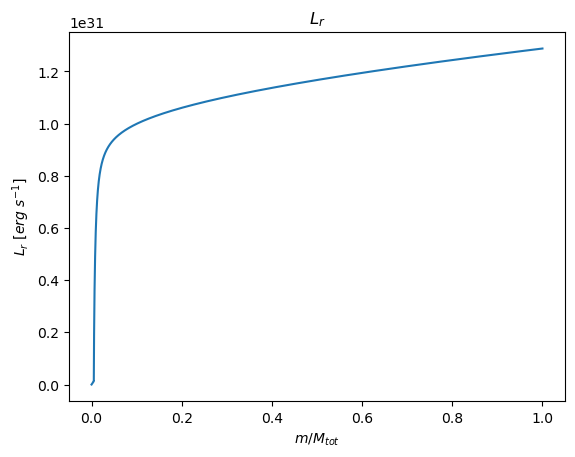

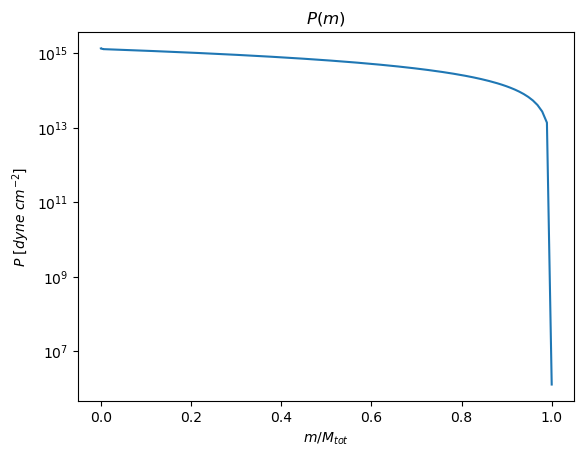

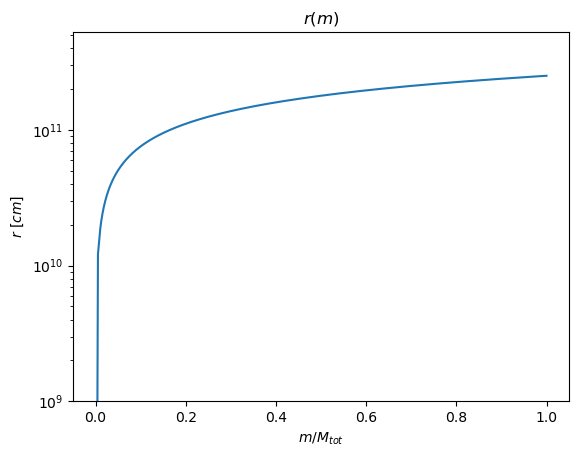

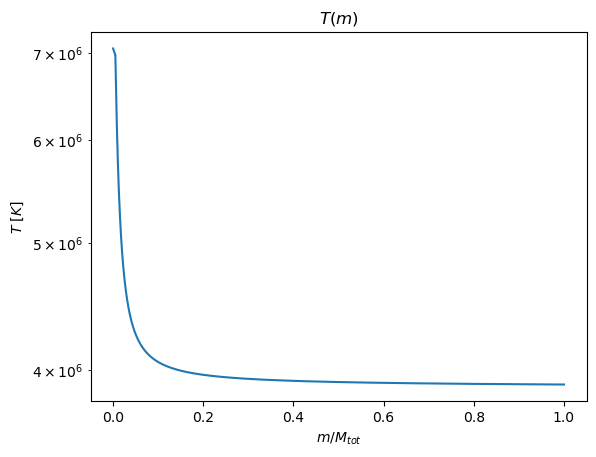

In [299]:
## Plotting
ms = np.append(np.array([0, np.exp(np.log(m_f)/2), m_f]), outwardpts)
l = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,0], outward_dep_params[:,0])
P = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,1], outward_dep_params[:,1])
r = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,2], outward_dep_params[:,2])
T = np.append(get_small_m_points(m_f, P_var= 1, T_var= 1)[:,3], outward_dep_params[:,3])
plt.plot(ms/ms[-1], l, label= "L")
plt.title(r"$L_r$")
plt.ylabel(r"$L_r\ [erg\ s^{-1}]$")
plt.xlabel(r"$m/M_{tot}$")
plt.show()
plt.semilogy(ms/ms[-1], P, label= "P")
plt.title(r"$P(m)$")
plt.ylabel(r"$P\ [dyne\ cm^{-2}]$")
plt.xlabel(r"$m/M_{tot}$")
plt.show()
plt.semilogy(ms/ms[-1], r, label= "r")
plt.title(r"$r(m)$")
plt.ylabel(r"$r\ [cm]$")
plt.xlabel(r"$m/M_{tot}$")
plt.ylim(1e9, None)
plt.show()
plt.plot(ms/ms[-1], T, label= "T")
plt.title(r"$T(m)$")
plt.ylabel(r"$T\ [K]$")
plt.xlabel(r"$m/M_{tot}$")
plt.show()

In [322]:
## Calculating other stellar parameters (\rho, opacity, \del_ad, \del_actual, convective/radiative)
## and gathering them into a machine readable table
## Cell outputs a csv file with name dir...\Stellar Parameters (ZAMS, X=.7,Y=.299,Z=.001).csv includes header and row labeling

def calc_all_params(m, calculated_params):
    
    l = calculated_params[0]
    P = calculated_params[1]
    r = calculated_params[2]
    T = calculated_params[3]
    
    l_0, P_c, r_0, T_c = interior_boundaries(P_var= 1, T_var= 1)
    rho_c = rho_of_P(P_c, T_c)
    
    rhos = np.zeros(len(P))
    kappas = np.zeros(len(P))
    epsilons = np.zeros(len(P))
    del_ad = np.zeros(len(P))
    del_actual = np.zeros(len(P))
    is_adiabatic = np.zeros(len(P), str) #.astype(str)
    
    for i in range(3):
        del_actual[i] = nabla_ad()
        del_ad[i] = nabla_ad()
        rhos[i] = rho_c
        kappas[i] = .2*(1+.34)
        epsilons[i] = epsilon_pp(T_c, rho_c) + epsilon_CNO(T_c, rho_c)
        is_adiabatic[i] = "convective"
    
    for i in range(len(P)-3):
        rhos[i+3] = rho_of_P(P[i+3], T[i+3])
        kappas[i+3] = get_opacity(T[i+3], r[i+3]/r[-1], opacity_table)
        del_ad[i+3] = nabla_ad()
        epsilons[i+3] = epsilon_pp(T[i+3], rhos[i+3]) + epsilon_CNO(T[i+3], rhos[i+3])
        if nabla_ad() > nabla_rad(m[i+3], l[i+3], P[i+3], T[i+3], kappas[i+3]):
            del_actual[i+3] = nabla_ad()
            is_adiabatic[i+3] = "convective"
        else:
            del_actual[i+3] = nabla_rad(m[i+3], l[i+3], P[i+3], T[i+3], kappas[i+3])
            is_adiabatic[i+3] = "radiative"
        
    d = {'Lagrangian mass': m, 
         'Radius': r, 
         'Density': rhos, 
         'Temperature': T, 
         'Pressure': P,               
         'Luminosity': l, 
         'E generation rate': epsilons, 
         'Opacity': kappas, 
         'Adiabatic temperature gradient': del_ad, 
         'Actual temperature gradient': del_actual, 
         'Energy transport': is_adiabatic}
    df = pd.DataFrame(data=d)    

    return df

df = calc_all_params(ms, [l, P, r, T])
df.to_csv('Stellar Parameters (ZAMS, X=.7,Y=.299,Z=.001).csv')

C:\Users\jaxon\AppData\Local\Temp\ipykernel_13032\3066212947.py:6: RuntimeWarning: invalid value encountered in double_scalars
  f11 = np.exp(5.92e-3 * Z1 * Z2 * (rho / (T/1e7)**3)**(1/2))
